In [77]:
import pandas as pd
import pandas_datareader as dr
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt

from analysis.data.utils_analysis import create_full_dataset
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data_tab = pd.read_html(snp500url)

tickers = data_tab[0][1:]['Symbol'].tolist()
print("Total number of tickers", len(tickers))

raw = yf.download(tickers, start="2018-01-01", end="2024-01-01", auto_adjust=True)["Close"]

Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['GEV', 'SW', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')


In [ ]:
from analysis.data.final_dataset import pipeline

dataset = pipeline()

Total number of tickers 502


[*************         28%                       ]  139 of 502 completed

In [1]:
dataset = pd.DataFrame(raw)
missing_frac = dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.2].index))
dataset.drop(columns=drop_list, axis = 1, inplace=True)
dataset.bfill(axis='index', inplace=True)
print('Null values:', dataset.isnull().values.any())


NameError: name 'pd' is not defined

In [79]:

returns = dataset.pct_change().mean()*252
returns = pd.DataFrame(returns)
final_dataframe = returns.reset_index()
final_dataframe = final_dataframe.rename(columns={final_dataframe.columns[1]:"Yavg_return"})
#volatility
final_dataframe["Yavg_volatility"] = np.array(dataset.pct_change().std()*np.sqrt(252))


In [80]:

for i in final_dataframe.columns:
    print(i)

Ticker
Yavg_return
Yavg_volatility


In [81]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ticker           485 non-null    object 
 1   Yavg_return      485 non-null    float64
 2   Yavg_volatility  485 non-null    float64
dtypes: float64(2), object(1)
memory usage: 11.5+ KB


In [82]:
outliers = final_dataframe[final_dataframe["Yavg_volatility"]>2]["Ticker"].unique()


    
    
i = 0

# plt.subplot(2,1,1)
for asset in outliers:
  if asset != "ADTX":
    prices = np.array(dataset[asset])
    plt.plot(prices, label = asset, color = f"C{i}")
    plt.legend()
    i += 1
# plt.subplot(2,1,2)
# prices = np.array(dataset["ADTX"])
# plt.plot(prices, label="ADTX", color = f"C{i}")
# plt.legend()
plt.show()

In [83]:
final_dataframe = final_dataframe[~final_dataframe["Ticker"].isin(outliers)]

In [84]:
stock_data_clustering = final_dataframe.copy()
for type, feature in zip(final_dataframe.dtypes, final_dataframe.columns):
    if type == "object" and feature!="Ticker":
        stock_data_clustering[feature] = final_dataframe[feature].astype('category').cat.codes

stock_data_clustering = stock_data_clustering.drop(columns=["Ticker"])
stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Yavg_return      485 non-null    float64
 1   Yavg_volatility  485 non-null    float64
dtypes: float64(2)
memory usage: 7.7 KB


In [85]:
from sklearn.preprocessing import StandardScaler
numerical_features = stock_data_clustering.select_dtypes(include=["float64", "int64"]).columns
categorical_features = stock_data_clustering.select_dtypes(include=["int8"]).columns
scaler = StandardScaler()
scaled_numerical = pd.DataFrame(scaler.fit_transform(stock_data_clustering[numerical_features]), columns=numerical_features)

# Combine scaled numerical features with categorical features
stock_data_clustering = pd.concat([scaled_numerical, stock_data_clustering[categorical_features].reset_index(drop=True)], axis=1)
stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Yavg_return      485 non-null    float64
 1   Yavg_volatility  485 non-null    float64
dtypes: float64(2)
memory usage: 7.7 KB


In [86]:
# for data manipulation
import numpy as np
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale (important in clustering)
from sklearn.preprocessing import StandardScaler

#---------------------------------------------------------------------
# to compute distances for the centroid methodology (KMeans)
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#----------------------------------------------------------------------
# to compute distances for the hierarchical clustering
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

#----------------------------------------------------------------------
# good practice
%matplotlib inline

# to remove warnings
# import warnings
# warnings.filterwarnings('ignore')

In [87]:
clusters = range(2, 50)
meanDistortions = []
sil_score = []
inertias = []
runs = 60
for i in range(runs):
    run_sil = []
    run_dist = []
    run_in = []
    for k in clusters:
        model = KMeans(n_clusters=k, random_state=i)
        model.fit(stock_data_clustering)
        prediction = model.predict(stock_data_clustering)
        score = silhouette_score(stock_data_clustering, prediction)
        distortion = (
            sum(
                np.min(cdist(stock_data_clustering, model.cluster_centers_, "euclidean"), axis=1)
            )
            / stock_data_clustering.shape[0]
        )
        run_in.append(model.inertia_)
        run_dist.append(distortion)
        run_sil.append(score)
    sil_score.append(run_sil)
    meanDistortions.append(run_dist)
    inertias.append(run_in)
        # print("\nNumber of Clusters:", k, "\tAverage Distortion:", distortion)
        # print("For n_clusters = {}, silhouette score is {}".format(k, score))

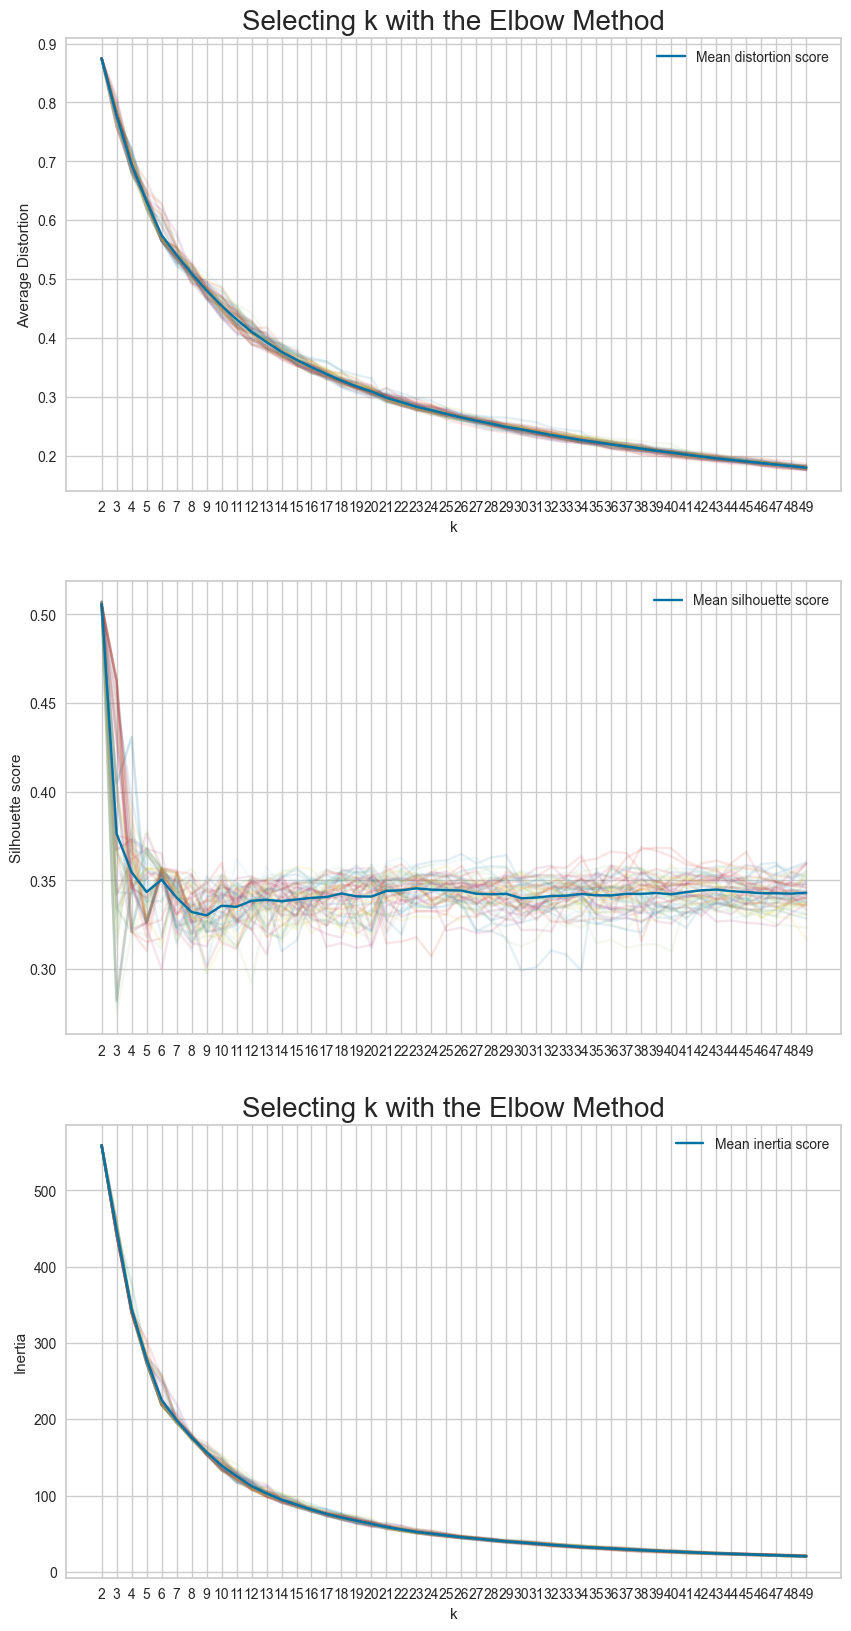

In [88]:
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
for i in range(runs): 
    plt.plot(clusters, meanDistortions[i], color=f"C{i}", alpha = 0.1)
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.xticks(clusters)
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.plot(clusters, np.mean(np.array(meanDistortions), axis=0), label="Mean distortion score")
plt.legend()
plt.subplot(3,1,2)
for i in range(runs): 
    plt.plot(clusters, sil_score[i], color=f"C{i}", alpha = 0.1)
plt.ylabel("Silhouette score")
plt.xticks(clusters)
plt.plot(clusters, np.mean(np.array(sil_score), axis=0), label="Mean silhouette score")
plt.legend()
plt.subplot(3,1,3)
for i in range(runs): 
    plt.plot(clusters, inertias[i], color=f"C{i}", alpha = 0.1)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(clusters)
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.plot(clusters, np.mean(np.array(inertias), axis=0), label="Mean inertia score")
plt.legend()
plt.show()

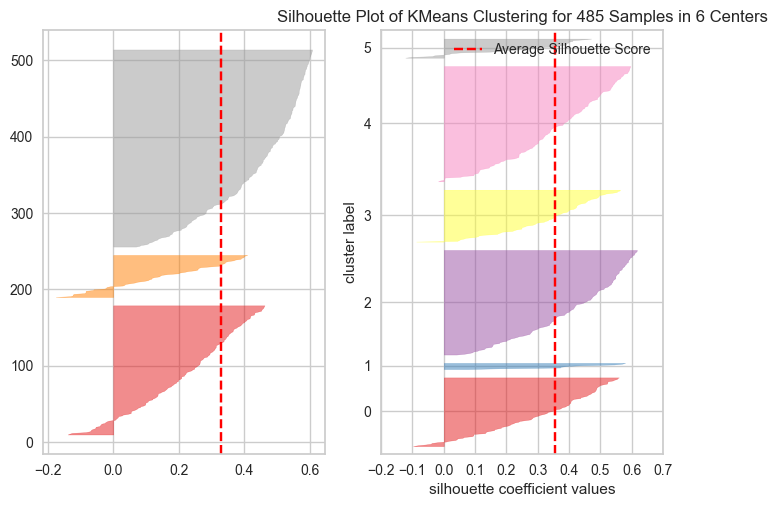

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 485 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [89]:
plt.subplot(1,2,1)
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [90]:
N_SECTORS = 6

kmeans = KMeans(n_clusters=N_SECTORS, random_state=0)
kmeans.fit(stock_data_clustering)
final_dataframe["K_means_segments"] = kmeans.labels_
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,K_means_segments
0,A,0.170254,0.290318,0
1,AAPL,0.309906,0.316770,4
2,ABBV,0.159055,0.273195,0
3,ABT,0.155088,0.257788,0
4,ACGL,0.204344,0.314158,0


In [101]:
cluster_profile = final_dataframe.groupby("K_means_segments").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("K_means_segments")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]
cluster_profile.style.highlight_max(color="green", axis=0)

,Yavg_return,Yavg_volatility,Count,Sharpe_ratio
K_means_segments,,,,
0,0.190737,0.305629,157,0.558641
1,0.171849,0.592759,18,0.256174
2,0.089964,0.391765,90,0.178586
3,0.583783,0.586995,9,0.960456
4,0.293733,0.415520,69,0.658771
5,0.088714,0.272381,142,0.252270


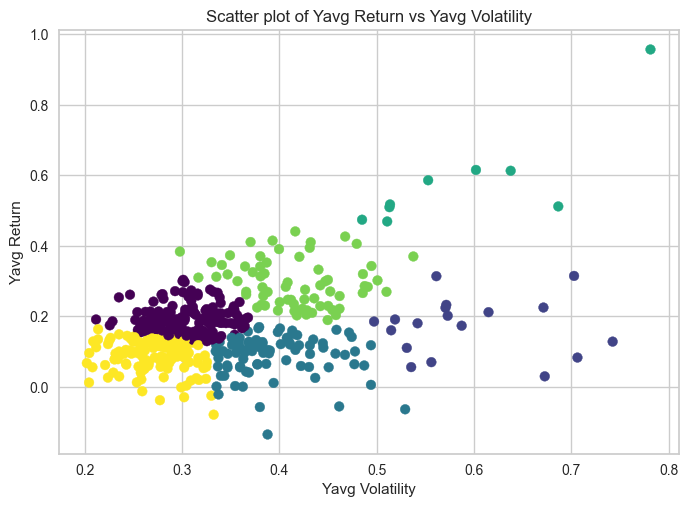

In [92]:
plt.scatter(
    final_dataframe["Yavg_volatility"], 
    final_dataframe["Yavg_return"], 
    c=final_dataframe["K_means_segments"],  # Use c for color mapping
    cmap='viridis'  # Optional: Choose a colormap
)

# Add labels and title
plt.xlabel("Yavg Volatility")
plt.ylabel("Yavg Return")
plt.title("Scatter plot of Yavg Return vs Yavg Volatility")

# Show the plot
plt.show()

In [93]:
portfolio_data= yf.download(tickers=list(final_dataframe["Ticker"]), start="2024-01-01", end="2025-01-25", auto_adjust=True)["Close"]

[*********************100%***********************]  485 of 485 completed


In [94]:
portfolio_dataset = pd.DataFrame(portfolio_data)
missing_frac = portfolio_dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.1].index))
portfolio_dataset.drop(columns=drop_list, axis = 1, inplace=True)
portfolio_dataset.ffill(axis='index', inplace=True)
print('Null values:', portfolio_dataset.isnull().values.any())

Null values: False


In [160]:
# pd.merge(portfolio_dataset, final_dataframe, on="Ticker")
portfolio_dataset = portfolio_dataset

# Example K_means_segments DataFrame
ticker_segments = pd.DataFrame({
    "Ticker": final_dataframe["Ticker"],
    "K_means_segments": final_dataframe["K_means_segments"],
})

# 1. Reshape daily_prices to long format
portfolio_dataset_long = portfolio_dataset.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Close")

# 2. Merge with ticker_segments to get segment information
merged_data = pd.merge(portfolio_dataset_long, ticker_segments, on="Ticker")

# 3. Calculate daily returns for each ticker
merged_data["Daily_Return"] = merged_data.groupby("Ticker")["Close"].pct_change()
merged_data = merged_data.dropna()
# 4. Group by Date and K_means_segments to calculate equally weighted portfolio returns
portfolio_returns = (
    merged_data.groupby(["Date", "K_means_segments"])["Daily_Return"]
    .mean()  # Equally weighted
    .reset_index()
)

# 5. Pivot the data for better visualization (optional)
portfolio_returns = portfolio_returns.pivot(
    index="Date", columns="K_means_segments", values="Daily_Return"
).dropna()


# Print results
print("Merged Data:\n", merged_data)
print("\nPortfolio Returns:\n", portfolio_returns)

Merged Data:
              Date Ticker       Close  K_means_segments  Daily_Return
1      2024-01-03      A  130.256180                 0     -0.054703
2      2024-01-04      A  130.097305                 0     -0.001220
3      2024-01-05      A  129.660339                 0     -0.003359
4      2024-01-08      A  132.460892                 0      0.021599
5      2024-01-09      A  129.779480                 0     -0.020243
...           ...    ...         ...               ...           ...
129490 2025-01-17    ZTS  165.389999                 0     -0.020547
129491 2025-01-21    ZTS  167.529999                 0      0.012939
129492 2025-01-22    ZTS  166.630005                 0     -0.005372
129493 2025-01-23    ZTS  166.960007                 0      0.001980
129494 2025-01-24    ZTS  168.610001                 0      0.009883

[129010 rows x 5 columns]

Portfolio Returns:
 K_means_segments         0         1         2         3         4         5
Date                             

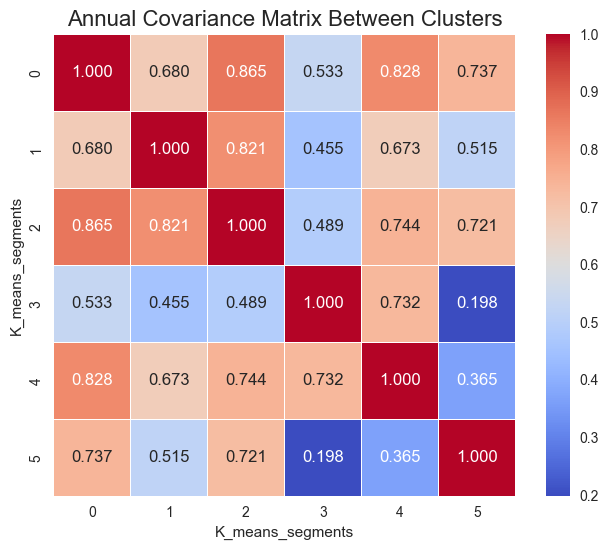

In [173]:

cov_matrix = portfolio_returns.corr()

# 2. Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(
    cov_matrix, 
    annot=True,  # Annotate the heatmap with the covariance values
    fmt=".3f",   # Format for the numbers
    cmap="coolwarm",  # Colormap for the heatmap
    linewidths=0.5,   # Add grid lines
    square=True       # Make the heatmap square
)

# 3. Add a title
plt.title("Annual Covariance Matrix Between Clusters", fontsize=16)
plt.show()

In [163]:
def weights(ratios, cluster, pow):
    ratios["weights"] = np.power(ratios["Sharpe_ratio"], pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["K_means_segments"] == cluster, "weights"]

In [171]:
import quantstats as qs

returns = np.zeros(len(portfolio_returns))
cp = cluster_profile.reset_index()
for i in portfolio_returns.columns:
        returns += weights(cp[["K_means_segments", "Sharpe_ratio"]], i, 2.5).values[0]*portfolio_returns[i] 
portfolio_performance = pd.DataFrame(returns).reset_index()
portfolio_performance

C:\Users\m.narese\AppData\Local\Temp\ipykernel_23840\1388605156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratios["weights"] = np.power(ratios["Sharpe_ratio"], pow)
C:\Users\m.narese\AppData\Local\Temp\ipykernel_23840\1388605156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
C:\Users\m.narese\AppData\Local\Temp\ipykernel_23840\1388605156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,Date,0
0,2024-01-03,-0.022850
1,2024-01-04,-0.001605
2,2024-01-05,0.005444
3,2024-01-08,0.030323
4,2024-01-09,0.001617
...,...,...
261,2025-01-17,0.010375
262,2025-01-21,0.015565
263,2025-01-22,0.009321
264,2025-01-23,0.012129


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-04   2024-01-04
End Period                 2025-01-24   2025-01-24
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          31.35%       29.01%
CAGR﹪                     19.49%       18.09%

Sharpe                     2.12         1.17
Prob. Sharpe Ratio         98.18%       88.51%
Smart Sharpe               2.08         1.15
Sortino                    3.11         1.77
Smart Sortino              3.06         1.74
Sortino/√2                 2.2          1.25
Smart Sortino/√2           2.16         1.23
Omega                      1.21         1.21

Max Drawdown               -8.41%       -16.14%
Longest DD Days            64           192
Volatility (ann.)          12.63%       22.93%
R^2                        0.64         0.64
Information Ratio          0.0          0.0
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-07-17,2024-08-07,2025-01-24,192,-16.136019,-14.627806
2,2024-03-08,2024-04-19,2024-05-23,77,-11.071424,-10.158526
3,2024-05-28,2024-07-01,2024-07-09,43,-4.569374,-3.877153
4,2024-02-16,2024-02-21,2024-02-21,6,-4.522952,-3.722834
5,2024-01-11,2024-01-17,2024-01-18,8,-2.180653,-1.563853


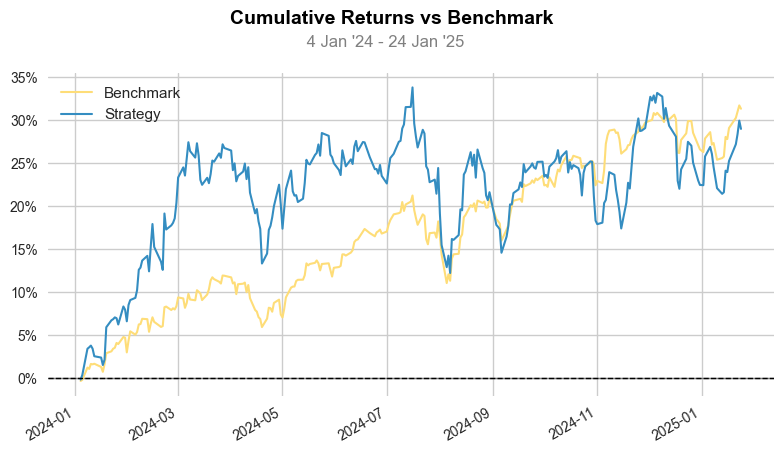

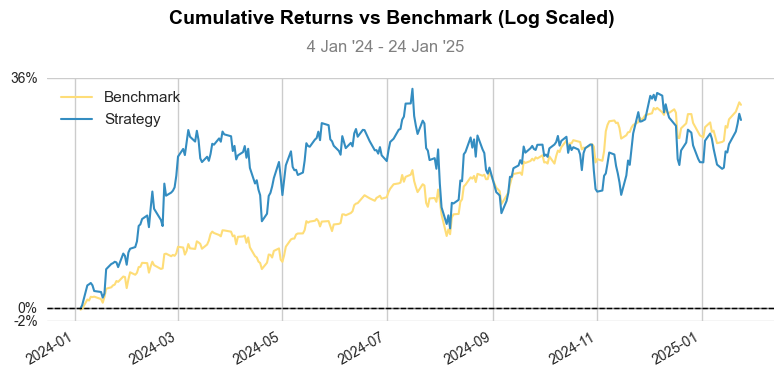

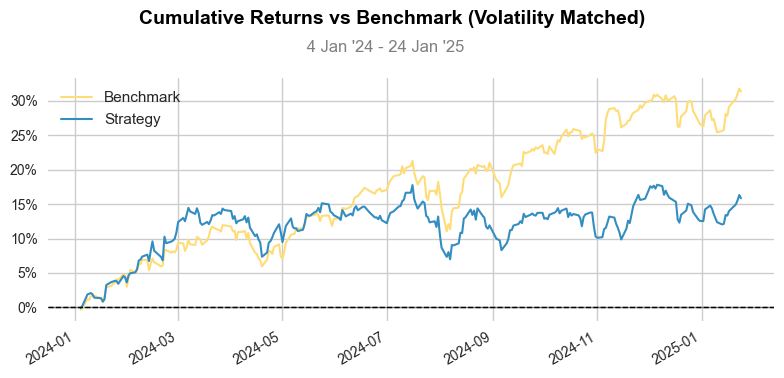

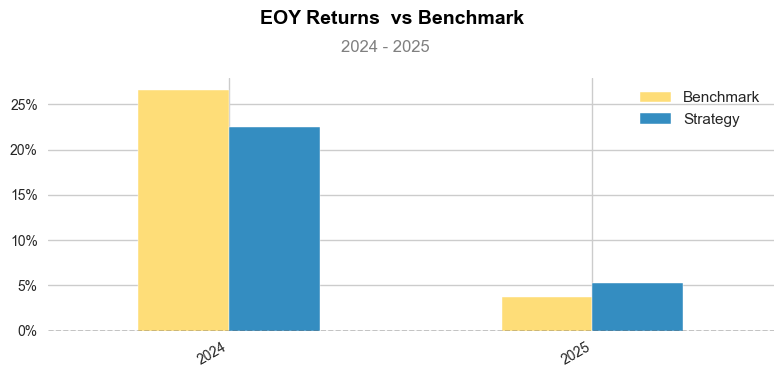

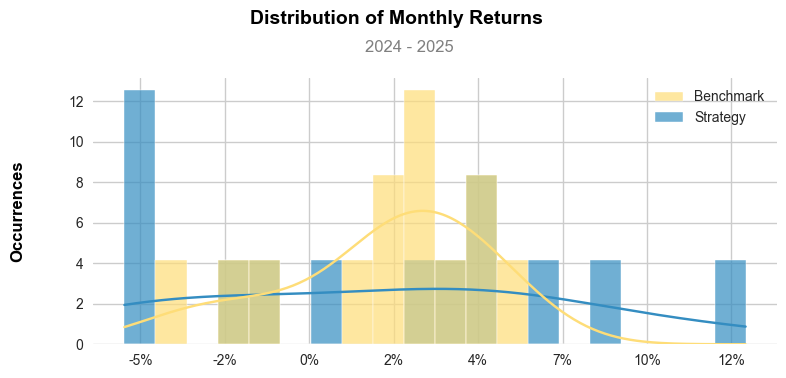

C:\Users\m.narese\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\quantstats\_plotting\core.py:294: FutureWarning: Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  returns = returns.last() if compound is True else returns.sum(axis=0)


UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [172]:
portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]

# Ensure the returns are properly formatted and call the quantstats report
qs.reports.full(portfolio_performance["Returns"], benchmark="SPY")

In [69]:
pr = portfolio_returns.reset_index()
pr[pr["Date"] > pd.to_datetime("2024-12-20")]

K_means_segments,Date,0,1,2,3
245,2024-12-23,0.004195,0.007809,0.008285,0.001691
246,2024-12-24,0.008732,-0.003404,0.015188,0.007176
247,2024-12-26,0.002614,-0.010290,0.027819,0.003039
248,2024-12-27,-0.009650,1.979713,-0.009068,-0.006809
249,2024-12-30,-0.005983,-0.026496,0.016839,-0.008847
250,2024-12-31,0.001720,0.179600,-0.027602,0.002299
251,2025-01-02,-0.001689,0.002042,0.024373,-0.004563
252,2025-01-03,0.014869,0.053555,0.021650,0.007363
253,2025-01-06,0.007759,0.022131,-0.005896,-0.001749
254,2025-01-07,-0.004927,-0.006233,0.010264,-0.002559
